<a href="https://colab.research.google.com/github/w95wayne10/personal_financial_management/blob/master/DH_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A hedger is short 10,000 European calls.  
As an option covers 100 shares of stock, N = 1,000,000.  


In [20]:
import numpy as np
np.set_printoptions(suppress=True)#, threshold=np.nan)

In [21]:
import matplotlib.pyplot as plt

In [22]:
path = [[(0, 0.927750771702379, 0.50492387781572)],
 [(-3, 0.3600648867148573, 0.27724626631432464),
  (0, 0.8055775046571824, 0.504310291948042),
  (3, 1.5883685589703163, 0.730177523716526)],
 [(-6, 0.06813446289248654, 0.07599625351242185),
  (-3, 0.2419495360439564, 0.23306119941252065),
  (0, 0.6888771040957733, 0.5038544764892775),
  (3, 1.4687311794220197, 0.7725553343754943),
  (6, 2.532378302725152, 0.9267069175805999)],
 [(-9, 0.0, 0.0),
  (-6, 5.676960427001858e-15, 6.6062202215069754e-15),
  (-3, 0.14824531971747984, 0.1792033133455514),
  (0, 0.5336035097784153, 0.5030407282742616),
  (3, 1.3738770478825733, 0.8251401380315196),
  (6, 2.462420253857317, 1.00000000091774),
  (9, 3.716276033166108, 1.0000000010471468)],
 [(-12, 0.0, 0.0),
  (-9, 0.0, 0.0),
  (-6, 0.0, 0.0),
  (-3, 1.414917823905559e-14, 1.7739603864255697e-14),
  (0, 0.38856261091164795, 0.5030407015277545),
  (3, 1.2237226232205356, 1.0),
  (6, 2.462420163760499, 1.0),
  (9, 3.716275927466316, 1.0),
  (12, 4.985475409349279, 1.0)],
 [(-15, 0, 0),
  (-12, 0, 0),
  (-9, 0, 0),
  (-6, 0, 0),
  (-3, 0, 0),
  (0, 4.263256414560601e-14, 1),
  (3, 1.223722561217457, 1),
  (6, 2.462420091503205, 1),
  (9, 3.7162758429322906, 1),
  (12, 4.985475310076737, 1),
  (15, 6.270206257447484, 1)]]

In [23]:
layer_num = len(path)
sample_size = 10000000
np.random.seed(1)
EPS = np.random.standard_normal((sample_size,layer_num-1))

In [24]:
#yt1 = yt0 + r - ht**2/2 + ht*epsilon
#Monte Carlo
S = 100
y0 = np.log(S)
YT = np.zeros((sample_size,layer_num))
YT[:,0] = y0
h = np.sqrt(10.96/1e5)
H = np.zeros((sample_size,layer_num))
H[:,0] = h
PRICE_PATH = np.zeros((sample_size,layer_num))
PRICE_PATH[:,0] = S
for t in range(layer_num-1):
  YT[:,t+1] = YT[:,t]-H[:,t]**2/2 + H[:,t]*EPS[:,t]
  H[:,t+1] = np.sqrt(0.000006575 + 0.9*H[:,t]**2 + 0.04*H[:,t]**2*EPS[:,t]**2)
  PRICE_PATH[:,t+1] = np.exp(YT[:,t+1])

In [25]:
NODE_PATH = np.zeros((sample_size,layer_num))
F = np.zeros((sample_size,layer_num))
DELTA = np.zeros((sample_size,layer_num))
for t in range(layer_num):
  temp = list(zip(*path[t]))
  node_idx = np.array(temp[0])
  NODE_PART = np.tile(np.exp(np.log(100)+node_idx*np.sqrt(0.00006575)/2),(sample_size,1))
  REAL_PART = np.tile(PRICE_PATH[:,t].reshape((sample_size,1)),(1,node_idx.shape[0]))
  odr = np.argmin(np.abs(REAL_PART - NODE_PART),axis= 1)
  NODE_PATH[:,t] = node_idx[odr]
  f_idx = np.array(temp[1])
  delta_idx = np.array(temp[2])
  F[:,t] = f_idx[odr]
  DELTA[:,t] = delta_idx[odr]
#NODE_PATH,F,DELTA

In [26]:
#hedge
S = 100
N = 1000000
NODE_INDEX = NODE_PATH.copy()
S = PRICE_PATH#np.exp(y)
CHANGE_DELTA = DELTA.copy()
CHANGE_DELTA[:, 1:] = DELTA[:, 1:]-DELTA[:, :-1]
SHARES_BOUGHT = N*CHANGE_DELTA
COST_SHARES = S*SHARES_BOUGHT
CUMULATIVE_COST = np.cumsum(COST_SHARES, axis=1)
result = N*F[:,0] - (CUMULATIVE_COST[:, -1] - N*S[:,0])
no_ex = ~DELTA[:,-1].astype(int).astype(bool)
result[no_ex] = N*F[no_ex,0] - CUMULATIVE_COST[no_ex, -1]

In [27]:
result.mean()/N,result.var()**0.5/N

(0.03232842894893319, 0.42581687784034483)

<a list of 75 Patch objects>

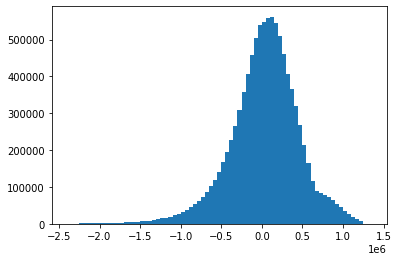

In [45]:
plt.hist(result,np.arange(-48,28)*1e5/2)[2]

In [36]:
check = NODE_PATH[:,-1].astype(int)==0

<a list of 75 Patch objects>

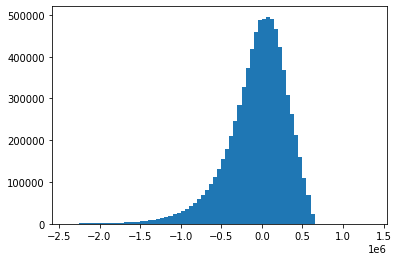

In [47]:
plt.hist(result[~check],np.arange(-48,28)*1e5/2)[2]

<a list of 75 Patch objects>

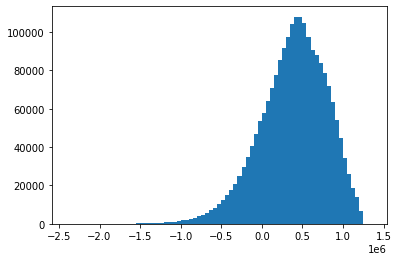

In [48]:
plt.hist(result[check],np.arange(-48,28)*1e5/2)[2]

In [52]:
check2 = PRICE_PATH[:,-1]>=100

<a list of 75 Patch objects>

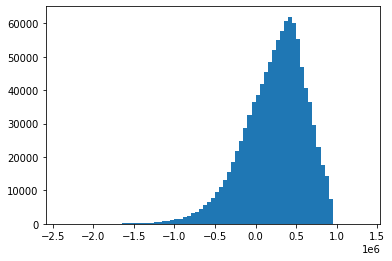

In [53]:
plt.hist(result[check&check2],np.arange(-48,28)*1e5/2)[2]

<a list of 75 Patch objects>

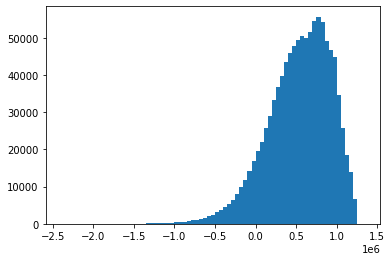

In [54]:
plt.hist(result[check&(~check2)],np.arange(-48,28)*1e5/2)[2]